**извлечение признаков из текста на естественном языке**

классификатор текстов TfidfVectorizer, вместо удаления стоп-слов используем обратную частоту IDF

_Евгений Борисов <esborisov@sevsu.ru>_

## библиотеки

In [1]:
import numpy as np
import numpy.random as rng

from tqdm.notebook import tqdm

import pandas as pd

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

In [2]:
from sklearn import __version__ as SKLEARN_VERSION

SKLEARN_VERSION

'1.0.2'

## тексты

In [4]:
# загружаем тексты
data = pd.read_pickle('../data/text/news.pkl.gz')
print('записей:',len(data))
data.sample(2)

записей: 3196


,text,tag
3053,Компания Красноярскэнерго предупреждает об опасности самовольного подключения к электрическим сетям. С начала 2010 года зарегистрировано три смертельных случая поражения током посторонних лиц на с...,incident
2173,"Лига определила лучших по итогам минувших семи дней.\n\nПервой звездой недели стал форвард Филадельфии Якуб Ворачек, который в четырех матчах набрал девять (3+6) очков.\n\nПри этом в двух встречах...",sport


## токенизация и очистка

In [5]:
import re

# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
       ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
       ,[r'\w+- ',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()

In [6]:
data['ctext'] = data['text'].progress_apply(string_normalizer)

  0%|          | 0/3196 [00:00<?, ?it/s]

##  Vectorizer

In [12]:
from nltk.stem.snowball import SnowballStemmer
# from nltk.corpus import stopwords as nltk_stopwords

# stopwords = set(nltk_stopwords.words('russian'))
stemmer = SnowballStemmer('russian')

# разрезаем стоки на слова, выкидываем stopwords, выполняем стеминг
def tokenizer_stemmer(s,stemmer=stemmer):  #,stopwords=stopwords): 
    for w in s.split(' '):
        o = stemmer.stem(w).replace('^','')
        if len(o)<2: continue
        # if o in stopwords: continue
        yield o        
    return ''

In [13]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(
        use_idf=True, 
        norm='l2', 
        tokenizer=tokenizer_stemmer, 
        token_pattern=None
    ).fit( data['ctext'] )

vcb1 = sorted(tf.vocabulary_)
print(len(vcb1))

36424
CPU times: user 1min 16s, sys: 41.4 ms, total: 1min 16s
Wall time: 1min 17s


In [14]:
# pd.DataFrame( vcb1 ).to_csv('voc1.txt',index=False,header=False)

pd.Series(vcb1).sample(30)

32274               тролл
20174           нордическ
11540               завел
27166               раскр
10772                дошл
23064              пикник
14690             колпачк
35639              ыоутуб
3464                zefir
8617         географическ
34048              фэллон
867          dynamo-brest
21664             отдален
8798          глиобластом
26546               пулюс
25438              придач
33808          фолк-групп
17944             младенц
35919    электроустановок
35768           экс-майор
33183              усмиря
20017         никифоровск
225              autostat
23549          подбадрива
3907        аккомпанемент
15747            кузьмицк
35431            шовковск
33174            усложнен
35413                шмел
12113              заразн
dtype: object

## формируем датасеты

In [15]:
%%time 

X = tf.transform( data['ctext'] )
X.shape

CPU times: user 1min 15s, sys: 29.5 ms, total: 1min 15s
Wall time: 1min 15s


(3196, 36424)

In [16]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [17]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9])

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2237, 36424), (2237,), (959, 36424), (959,))

## обучаем классификатор

In [19]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19)
clf.fit(X_train,y_train)

SGDClassifier(tol=0.19)

## тестируем

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [21]:
# доля правильных ответов на учебном наборе
o = clf.predict(X_train)
accuracy_score(y_train,o)

0.9995529727313366

In [22]:
# доля правильных ответов на тестовом наборе
o = clf.predict(X_test)
accuracy_score(y_test,o)

0.8748696558915537

In [23]:
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        87
           1       0.81      0.94      0.87       101
           2       0.87      0.79      0.83        76
           3       0.85      0.74      0.79        31
           4       0.87      0.94      0.91       123
           5       0.89      0.95      0.92       177
           6       0.83      0.71      0.77        21
           7       1.00      0.41      0.58        17
           8       0.88      1.00      0.94        68
           9       0.60      0.34      0.43        44
          10       0.97      1.00      0.98       118
          11       0.86      0.79      0.82        89
          12       0.83      0.71      0.77         7

    accuracy                           0.87       959
   macro avg       0.86      0.79      0.81       959
weighted avg       0.87      0.87      0.87       959



---

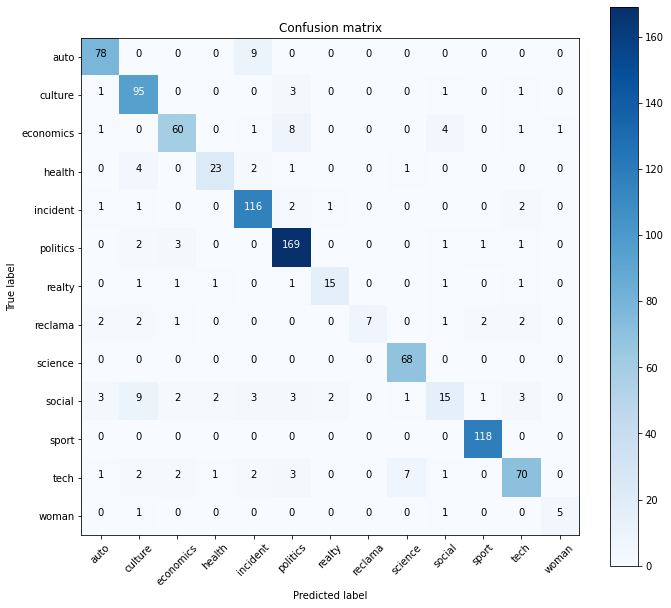

In [24]:
from matplotlib import pyplot as plt
import itertools

classes = sorted(labels.keys())
cm = confusion_matrix(y_test,o)
tick_marks = np.arange(len(classes))

plt.figure(figsize=(10,9))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.title('Confusion matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

plt.show()

---

In [25]:
o = clf.predict(X)

In [26]:
labels_inv = { labels[k]:k for k in labels }
# labels_inv

In [27]:
for n in range(10):
    i = rng.randint(len(data))
    print('tag:',data.iloc[i,1])
    print('predict:',labels_inv[o[i]])
    print(re.sub(r'\n\s*\n',' ',data.iloc[i,0][:200])+'...')
    print('- - - - - - - - - - - - - - - - - -')
    

tag: tech
predict: tech
Новые Android-смартфоны Nokia появятся в начале 2017 года 1 декабря 2016 в 15:56 42.TUT.BY Компания Nokia объявила о завершении сделки с HMD Global, которая получает права на производство мобильных...
- - - - - - - - - - - - - - - - - -
tag: politics
predict: politics
Карелия (Петрозаводск) Братья по группе В составе делегации из Эстонии
представители государственных структур, общественных организаций.  -
Тере, - приветствовали гостей из Эстонии в Центре национальн...
- - - - - - - - - - - - - - - - - -
tag: incident
predict: incident
Сотрудница отдела полиции подмосковного Серпухова, которая на личном автомобиле в неслужебное время сбила насмерть двух человек, уволена из органов внутренних дел по отрицательным мотивам. Об этом в п...
- - - - - - - - - - - - - - - - - -
tag: realty
predict: realty
В гостях у дизайнера. В доме с черно-белым фасадом и плоской крышей 4 декабря 2016 в 9:00 Карина Комиссарчик, Realt.by За последние несколько лет мы много материалов п

In [28]:
# https://habr.com/ru/post/205360/